# Setting

In [1]:
from pf_utils import BacktestManager, DataManager, StaticPortfolio, MomentumPortfolio, AssetEvaluator

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
metrics2 = [
    'cagr', 'monthly_vol', 'monthly_sharpe',
    'max_drawdown', 'avg_drawdown','avg_drawdown_days', 
]

path_data = 'data'
path_tran = 'transaction'

# Universe

In [3]:
file_k200 = 'kospi200_prices_240710.csv'
file_etf = 'etfs_all_240710.csv'
download = False

## KOSPI200

In [4]:
k200 = DataManager(
    file = file_k200,
    universe = 'KOSPI200',
    path = path_data
)
k200.upload()

200 assets from 2021-01-04 to 2024-07-10 uploaded.
df_prices updated


In [5]:
kw = dict(
    n_years=3, 
    close_today=True,
    #tickers=k200.df_prices.columns
)
k200.download(**kw) if download else None

In [6]:
df_k200 = k200.df_prices
assetnames_k200 = k200.get_names()

## ETF

In [7]:
etf = DataManager(
    file = file_etf,
    universe = 'ETF',
    path = path_data
)
etf.upload()

870 assets from 2021-01-04 to 2024-07-10 uploaded.
df_prices updated


In [8]:
kw = dict(
    n_years=3, 
    close_today=True,
    #tickers=etf.df_prices.columns
)
etf.download(**kw) if download else None

In [9]:
choice = ['069500', '273130', '148070', '379800', '411060', '284430']
df_etf = etf.df_prices[choice]
assetnames_etf = etf.get_names(tickers=choice)
assetnames_etf

0) 069500: KODEX 200
1) 273130: KODEX 종합채권(AA-이상)액티브
2) 148070: KOSEF 국고채10년
3) 379800: KODEX 미국S&P500TR
4) 411060: ACE KRX금현물
5) 284430: KODEX 200미국채혼합

# Backtest

## KOSPI 200

In [10]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 1, 
    days_in_year = 246,
    asset_names = assetnames_k200
)
bm = BacktestManager(df_k200, **kwargs_bm)

15 assets removed for shorter periods (7.5%)
running self.util_check_days_in_year to check days in a year


In [11]:
lags = dict(lookback=12, lag=5)

In [12]:
bm.benchmark_ticker(**lags)

Benchmark is KODEX200


In [13]:
select = 'Momentum'
kwargs_build = dict(
    name=f'KOSPI:{select}', select =select,
    freq='M', weigh = 'ERC',
    n_assets=5, **lags
)
bm.build(**kwargs_build)

In [14]:
select = 'K-ratio'
kwargs_build.update(dict(
    name=f'KOSPI:{select}', select =select,
))
bm.build(**kwargs_build)

Backtesting 2 strategies: KODEX200, KOSPI:Momentum


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.54it/s]

Returning stats


,KOSPI:Momentum,KODEX200
start,2021-01-03,2021-01-03
end,2024-07-10,2024-07-10
cagr,0.728994,0.020773
monthly_vol,0.467373,0.174975
monthly_sharpe,1.399333,0.204963
max_drawdown,-0.262851,-0.278222
avg_drawdown,-0.059227,-0.061003
avg_drawdown_days,17.488372,180.0


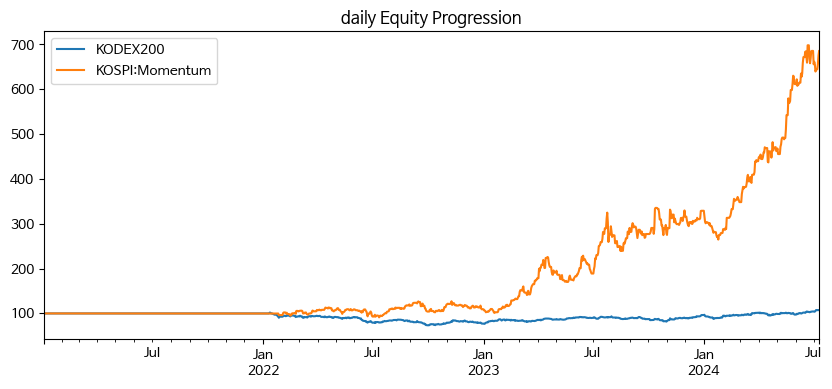

In [14]:
bm.run(figsize=(10,4), metrics=metrics2, stats_sort_by='monthly_sharpe')

In [15]:
df_pf = bm.get_historical()
df_pf = df_pf[['KODEX200','KOSPI:Momentum']]
df_pf.head()

,KODEX200,KOSPI:Momentum
2022-01-10,100.0000,NaN
2022-01-11,100.2997,NaN
2022-01-12,101.9359,NaN
2022-01-13,101.4175,NaN
2022-01-14,99.8488,NaN


## ETF

In [16]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 0, 
    days_in_year = 245,
    asset_names = assetnames_etf
)
bm = BacktestManager(df_etf, **kwargs_bm)

period reset: 2021-12-15 ~ 2024-07-10
running self.util_check_days_in_year to check days in a year


In [17]:
lags = dict(lookback=12, lag=5)

In [18]:
bm.benchmark_ticker(**lags)

Benchmark is KODEX200


In [19]:
kwargs_build = dict(
    freq = 'Y', select = 'all',
    **lags # added to start backtest on same date with momentum
)

bm.build(name='ETF:Eqaully', weigh='equally', **kwargs_build)
bm.build(name='ETF:ERC', weigh='ERC', **kwargs_build)
bm.build(name='ETF:InvVol', weigh='InvVol', **kwargs_build)

Backtesting 4 strategies: KODEX200, ETF:Eqaully, ETF:ERC, ETF:InvVol


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.01it/s]


Returning stats


,ETF:Eqaully,ETF:ERC,ETF:InvVol,KODEX200
start,2021-12-14,2021-12-14,2021-12-14,2021-12-14
end,2024-07-10,2024-07-10,2024-07-10,2024-07-10
total_return,0.261244,0.214048,0.190885,0.341347
cagr,0.094482,0.078365,0.070315,0.121013
calmar,2.570011,2.036211,1.863784,0.960111
max_drawdown,-0.036763,-0.038486,-0.037727,-0.126041
avg_drawdown,-0.007851,-0.007471,-0.00685,-0.025636
avg_drawdown_days,12.771429,17.346154,17.461538,19.68
daily_vol,0.046101,0.040422,0.038887,0.125812
daily_sharpe,2.030856,1.93376,1.810946,0.993648


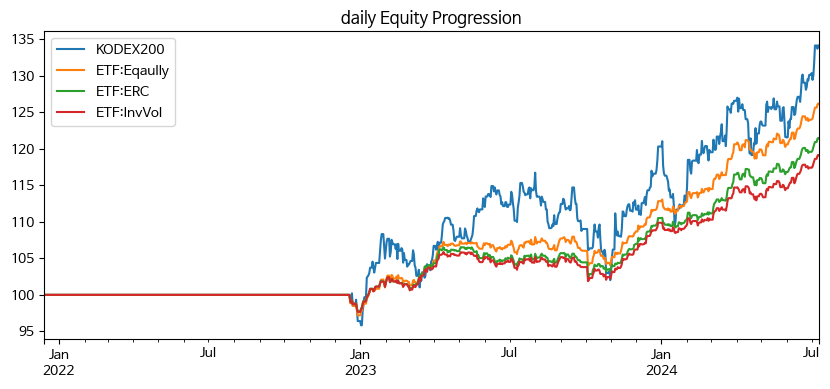

In [20]:
bm.run(figsize=(10,4), stats_sort_by='monthly_sharpe')

In [21]:
df = bm.get_historical()
df_pf = df_pf.join(df[['ETF:Eqaully', 'ETF:ERC']])

## Summary

In [22]:
ae = AssetEvaluator(df_pf, 245)

ETF:Eqaully: 244
ETF:ERC: 244


In [23]:
ae.get_stats(sort_by='monthly_sharpe', align_period=False)

,ETF:Eqaully,ETF:ERC,KOSPI:Momentum,KODEX200
start,2022-12-19,2022-12-19,2022-01-25,2022-01-10
end,2024-07-10,2024-07-10,2024-07-10,2024-07-10
total_return,0.261244,0.214048,5.853925,0.074952
cagr,0.160659,0.132589,1.18971,0.029369
calmar,4.37009,3.44514,4.526184,0.10556
max_drawdown,-0.036763,-0.038486,-0.262851,-0.278222
avg_drawdown,-0.007851,-0.007471,-0.059227,-0.061003
avg_drawdown_days,12.771429,17.346154,17.488372,180.0
daily_vol,0.059009,0.051766,0.467761,0.173421
daily_sharpe,2.624961,2.498196,1.953838,0.257587


# Transaction

## KOSPI200

In [24]:
kwargs = dict(
    name='KOSPI Momentum',
    file='pf_k200_momentum.csv',
    method_select='Simple', method_weigh='ERC', lookback=12, lag=5,
    path=path_tran,
    days_in_year=246,
    asset_names=assetnames_k200,
)

pf_k200 = MomentumPortfolio(df_k200, **kwargs)

15 assets removed for shorter periods (7.5%)
running self.util_check_days_in_year to check days in a year
Transaction record to 2024-07-10 loaded.


In [25]:
kwargs = dict(
    #date = '2024-01-01',
    #date = '2024-03-01',
    date = None,
    save = True
)
df = pf_k200.transaction_pipeline(**kwargs)

5 assets selected by Total return from 2023-07-05 to 2024-07-05
ERROR: check the date as no new transaction


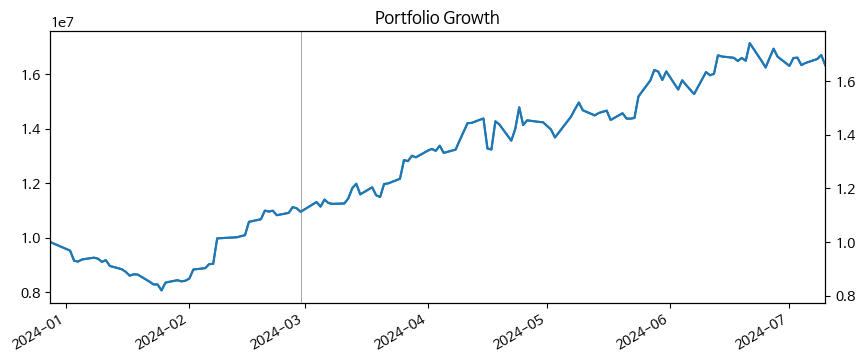

In [26]:
pf_k200.plot()

In [32]:
#pf_k200.performance(metrics=metrics2)
df_pf = pf_k200.get_historical()

## ETF

In [28]:
kwargs = dict(
    name='ETF6',
    file='pf_etf_static.csv',
    method_weigh='ERC', lookback=12, lag=5,
    path=path_tran,
    days_in_year=245,
    asset_names=assetnames_etf,
)

pf_etf = StaticPortfolio(df_etf, **kwargs)

period reset: 2021-12-15 ~ 2024-07-10
running self.util_check_days_in_year to check days in a year
Transaction record to 2024-07-01 loaded.


In [29]:
pf_etf.transaction_pipeline(save=False)

6 assets from 2023-07-05 to 2024-07-05 prepared for weight analysis
Weights of assets determined by ERC.
Net profit: 1,020,814
Set save=True to save transaction record


name   price  transaction  net weight
date       asset                                                        
2023-12-28 069500             KODEX 200   35635           29   29   0.10
           148070          KOSEF 국고채10년  112490           14   14   0.16
           273130  KODEX 종합채권(AA-이상)액티브  109855           22   22   0.24
           284430        KODEX 200미국채혼합   12580          129  129   0.16
           379800      KODEX 미국S&P500TR   13955          112  112   0.16
           411060            ACE KRX금현물   12330          135  135   0.17
2024-02-29 069500             KODEX 200   35404           -1   28   0.10
           148070          KOSEF 국고채10년  110565            0   14   0.16
           273130  KODEX 종합채권(AA-이상)액티브  109025            0   22   0.25
           284430        KODEX 200미국채혼합   12585           -6  123   0.16
           379800      KODEX 미국S&P500TR   15300           -5  107   0.17
           411060            ACE KRX금현물   12465           -6  129   0.17
2024-04-30 069500             KODEX 200   36650           -3   25   0.09
           148070          KOSEF 국고채10년  109870            1   15   0.17
           273130  KODEX 종합채권(AA-이상)액티브  109185            1   23   0.26
           284430        KODEX 200미국채혼합   12805            1  124   0.16
           379800      KODEX 미국S&P500TR   16030          -10   97   0.16
           411060            ACE KRX금현물   14800          -31   98   0.15
2024-07-01 069500             KODEX 200   38620           -3   22   0.08
           148070          KOSEF 국고채10년  113225            1   16   0.18
           273130  KODEX 종합채권(AA-이상)액티브  111595            2   25   0.28
           284430        KODEX 200미국채혼합   13260           -1  123   0.16
           379800      KODEX 미국S&P500TR   17180           -5   92   0.16
           411060            ACE KRX금현물   14755            0   98   0.14
2024-07-10 069500             KODEX 200   39735            1   23   0.08
           148070          KOSEF 국고채10년  114330            1   17   0.18
           273130  KODEX 종합채권(AA-이상)액티브  112380            1   26   0.27
           284430        KODEX 200미국채혼합   13490            6  129   0.16
           379800      KODEX 미국S&P500TR   17560            5   97   0.16
           411060            ACE KRX금현물   15005            5  103   0.14

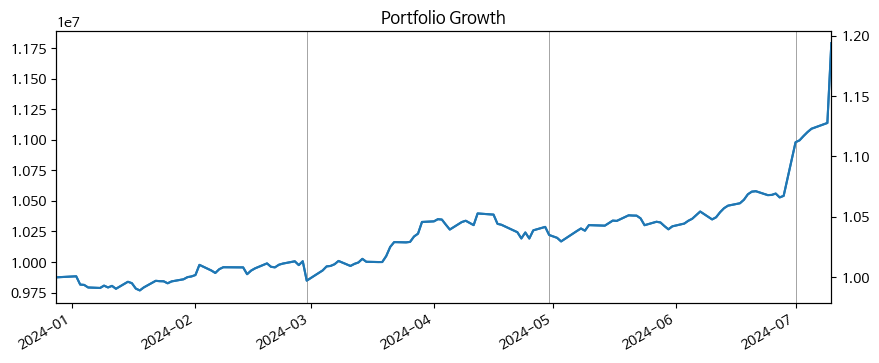

In [31]:
pf_etf.plot()

In [35]:
df_pf = df_pf.to_frame().join(pf_etf.get_historical())
df_pf.tail()

,KOSPI Momentum,ETF6
2024-07-04,16337050,11062309.0
2024-07-05,16412850,11089604.0
2024-07-08,16559650,11125064.0
2024-07-09,16707450,11136904.0
2024-07-10,16331600,11789254.0


In [37]:
ae = AssetEvaluator(df_pf, 245)
ae.get_stats(sort_by='monthly_sharpe')

KOSPI Momentum: 242
ETF6: 242


,ETF6,KOSPI Momentum
start,2023-12-28,2023-12-28
end,2024-07-10,2024-07-10
total_return,0.193798,0.658603
cagr,0.39347,1.57985
calmar,17.895167,8.772432
max_drawdown,-0.021988,-0.180093
avg_drawdown,-0.007464,-0.039306
avg_drawdown_days,11.583333,9.0
daily_vol,0.114809,0.403122
daily_sharpe,3.071686,2.654245
